In [1]:
import sys
sys.path.append('../python')

In [12]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2
from diffusers import utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
from copy import deepcopy

# user's libraries
from functions import *
from model import mlp,lstm,cnn_lstm

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = (
    'cuda' 
    if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(device)

mps


-train.csv: A training dataset comprising 60’000 photoplethysmography (PPG) signals sampled at 100 Hz (30-second duration each), as well as five additional features.
First 3000 labelled columns (ppg_0,…, ppg_2999) correspond to the time series of the raw input optical signal.
Last 5 labelled columns (feature_0,…,feature_4) correspond to engineered features containing relevant information.
<br>-train_labels.csv: continuous labels.
<br>-test.csv: A test dataset comprising 30’000 recordings with no labels, with the same format as the train.csv file.
The password to download the data is: cheese! Please let us know if you experience any issues.
 

The idea is to spend a maximum of 12 hours to:

·                     Use the training set to design a deep learning-based solution to predict the continuous labels of these PPG signals.

·                     Generate the outputs for the 30’000 recordings of the test dataset and share the obtained outputs as well as your code by email at the latest on the Monday 23rd of June (in the morning)

·                     Report and present your approach, results and findings in a maximum of five slides during the next interview. You will have 15-20 minutes for your presentation followed by a 10-15 minutes Q&A.

 

While the performance of your proposed approach is important to us, we are equally interested in your creativity and how you present your work and results. The interview will take place at our office in Neuchâtel and will also be an opportunity to meet other members of the Aktiia Team.

## TODO
* check ouptut for windows
* Define baseline
* make sure test and val are from the same distribution

# 0. Imports

In [4]:
train_df = pd.read_csv('../data/train.csv')#.head(5000)
print(train_df.shape)
# train.head()

(60000, 3005)


In [5]:
train_l = pd.read_csv('../data/train_labels.csv')#.head(5000)
print(train_l.shape)
# train_l.head()

(60000, 1)


In [6]:
train_df['label'] = train_l['target']
print(train_df.shape)
train_df

(60000, 3006)


,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,...,ppg_2996,ppg_2997,ppg_2998,ppg_2999,features_0,features_1,features_2,features_3,features_4,label
0,2495829.8,2496739.2,2494858.2,2492765.2,2491843.5,2494595.0,2492085.0,2490652.5,2490777.2,2496773.8,...,2419126.0,2418873.2,2416466.5,2428702.8,-1.251488,1.009981,0.603974,0.252646,1.949994,2.641616
1,2501260.0,2501346.0,2501102.5,2500992.2,2500849.5,2500811.5,2500517.5,2500474.2,2500427.2,2500511.2,...,2420832.8,2420860.2,2421016.8,2420952.0,0.087479,1.475090,0.033434,0.252646,0.715404,-0.535309
2,2501591.0,2502997.0,2511711.8,2501036.2,2496703.5,2503340.8,2498449.8,2493474.8,2505062.5,2497219.8,...,2421374.5,2423805.2,2422972.8,2423857.0,-0.715901,1.087499,0.603974,0.252646,1.209240,5.717096
3,2517803.5,2507316.5,2514108.2,2517570.8,2513305.8,2514936.0,2510431.0,2514905.8,2515988.8,2510290.5,...,2434174.0,2437226.2,2432477.2,2431346.5,1.069389,0.002245,-1.250281,0.252646,-0.272268,3.789291
4,2513730.2,2519822.8,2512720.8,2509725.5,2503305.5,2491827.2,2512113.8,2514973.2,2512475.0,2509586.2,...,2439123.5,2449905.8,2444987.5,2456793.8,-0.626637,0.932463,1.174513,0.252646,0.550792,4.469064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2512603.0,2512974.8,2513241.5,2513372.2,2513600.8,2513544.5,2513225.8,2512938.2,2512654.5,2512338.5,...,2452234.8,2451847.5,2451535.5,2451152.0,1.426447,0.157281,-0.394471,0.252646,-1.013022,-8.862518
59996,2498888.2,2487009.8,2477404.2,2492512.2,2501709.2,2504482.2,2499458.0,2514006.8,2500739.5,2502149.2,...,2417705.0,2439524.0,2436796.8,2426096.0,-0.269579,1.320054,1.745053,0.252646,0.880016,6.142950
59997,2502595.2,2494223.0,2506181.0,2500493.8,2510853.0,2494564.2,2496517.2,2503081.0,2498094.8,2513468.5,...,2417523.2,2408580.5,2417546.8,2428234.2,0.712331,0.932463,0.603974,0.252646,0.221568,2.896127
59998,2506344.0,2499414.0,2504447.2,2507816.2,2506179.0,2503351.5,2498943.0,2496620.8,2497910.0,2505747.2,...,2426865.5,2419689.5,2425549.8,2418134.5,-1.162224,1.242536,1.031878,0.252646,-0.354574,1.585697


In [7]:
# test_f = pd.read_csv('../data/Aktiia/test.csv').values.astype('float32')
# print(test_f.shape)
# test_f.head()

## 1. Data Pre-processing

In [8]:
# ## display mean ppg at teach timestep and standard deviation
# s = 50
# plt.plot(ppg_t['mean'][:s])
# plt.fill_between(range(s),ppg_t['mean'][:s]-ppg_t['std'][:s],ppg_t['mean'][:s]+ppg_t['std'][:s],alpha=.1)
# plt.show()

In [13]:
%%time
## get train, validation & test sets from training data
X = train_df.drop('label',axis=1)
n = len(X) # size of train dataset
y = train_df[['label']]

## train-validation-test split for time series

X_raw_train, X_raw_val, X_raw_test = X[0:int(n*0.7)], X[int(n*0.7):int(n*0.9)], X[int(n*0.9):]
y_raw_train, y_raw_val, y_raw_test = y[0:int(n*0.7)], y[int(n*0.7):int(n*0.9)], y[int(n*0.9):]

## feature scaling:
train_mean = X_raw_train.mean()
train_std  = X_raw_train.std()

X_raw_train = (X_raw_train - train_mean) / train_std
X_raw_val   = (X_raw_val - train_mean) / train_std
X_raw_test  = (X_raw_test - train_mean) / train_std

CPU times: user 701 ms, sys: 982 ms, total: 1.68 s
Wall time: 826 ms


In [14]:
%%time
lookback = 1
X_train, y_train = create_dataset(X_raw_train, y_raw_train, lookback=lookback,v=False)
X_val, y_val     = create_dataset(X_raw_val, y_raw_val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([41999, 1, 3005]) torch.Size([41999, 1, 1])
torch.Size([11999, 1, 3005]) torch.Size([11999, 1, 1])
CPU times: user 8.67 s, sys: 162 ms, total: 8.83 s
Wall time: 8.83 s


## Training the Deep Learning Models to predict label

In [ ]:
if 1<3:
    ## single forward pass in batches to make sure everything works!
    h_s             = 32
    input_size      = X_train.shape[-1]
    conv_c1         = 4 # number of channels for conv1
    conv_c2         = 4 # number of channels for conv1
    batch_size      = 16
    model           = cnn_lstm(h_s,input_size,conv_c1,conv_c2) # lstm(h_s, input_size) # mlp(input_size) # 
    optimizer       = optim.Adam(model.parameters(),lr=1e-5,)
    loss_fn         = nn.MSELoss()
    loader          = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
     
    n_epochs = 1
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)#.reshape(y_batch.shape[0],1)
            break
y_pred.shape

In [16]:
## check Baseline model:
y_val_np = y_val.detach().numpy().flatten()
y_val_nofirst = torch.tensor(np.delete(y_val_np, 0))
y_val_nolast  = torch.tensor(np.delete(y_val_np, -1))

loss_fn       = nn.MSELoss()
base_rmse     = np.sqrt(loss_fn(y_val_nofirst, y_val_nolast))
print('>> Baseline rmse:',base_rmse.numpy())

>> Baseline rmse: 7.1588063


In [39]:
class PARAMS():
    def __init__(self):
        self.input_size  = None
        self.hidden_size = None
        self.conv_c1     = None
        self.conv_c2     = None
        self.batch_size  = None

In [41]:
## simple training of the model
params = PARAMS()
params.hidden_size = 32
params.input_size  = X_train.shape[-1]
params.batch_size  = 64
params.conv_c1     = 4 # number of channels for conv1
params.conv_c2     = 4 # number of channels for conv1
loss_fn            = nn.MSELoss()

# model           = cnn_lstm(h_s,input_size,conv_c1,conv_c2) # mlp(input_size) # lstm(h_s, input_size) #
models = {'mlp':mlp,
          'lstm':lstm,
          'cnn_lstm':cnn_lstm
         }

torch.manual_seed(0)
loader          = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
model           = models['lstm'](params)
optimizer       = optim.Adam(model.parameters(),lr=1e-4,)

n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)#.reshape(y_batch.shape[0],1)
        loss = loss_fn(y_pred, y_batch)
        # print(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        # Checking rsme on whole training set
        y_pred_t   = model(X_train)#.reshape(y_train.shape[0],1)
        train_rmse = np.sqrt(loss_fn(y_pred_t, y_train))
        # Checking rsme on validation set
        y_pred_v = model(X_val)#.reshape(y_val.shape[0],1)
        val_rmse = np.sqrt(loss_fn(y_pred_v, y_val))
        # save model params
        
        
    print("Epoch %d: train RMSE %.4f, validation RMSE %.4f" % (epoch, train_rmse, val_rmse))
    # break

  2%|▉                                           | 1/50 [00:00<00:28,  1.74it/s]

Epoch 0: train RMSE 3.7285, validation RMSE 3.8482


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.89it/s]

Epoch 10: train RMSE 2.5703, validation RMSE 2.9942


 42%|██████████████████                         | 21/50 [00:10<00:15,  1.93it/s]

Epoch 20: train RMSE 1.8217, validation RMSE 2.4749


 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.88it/s]

Epoch 30: train RMSE 1.2420, validation RMSE 2.0664


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.89it/s]

Epoch 40: train RMSE 1.2951, validation RMSE 2.1512


100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


>> RMSE train: 1.3131895


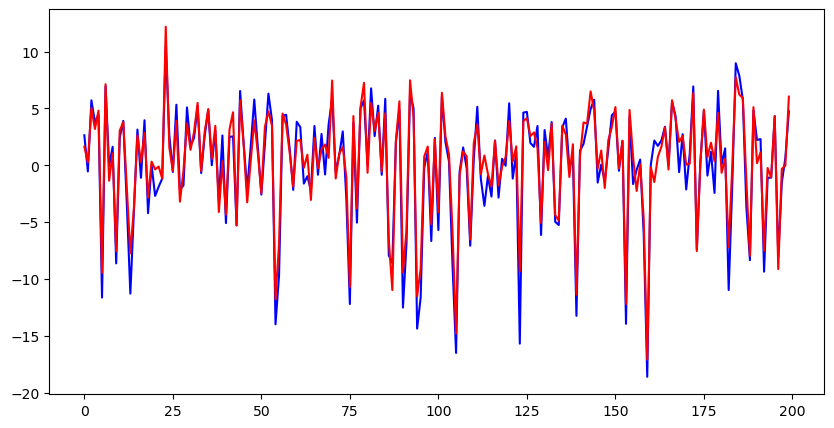

In [42]:
## plot training set results:
with torch.no_grad():
    y_real = y_train[:, -1, :]
    y_hat  = model(X_train)[:, -1, :] # you take the last prediction (last of 2nd element of 3D tensor)
    print('>> RMSE train:',np.sqrt(loss_fn(y_hat, y_real)).detach().numpy() )
# plot
plt.figure(figsize=(10,5))
plt.plot(y_real[:200], c='b')
plt.plot(y_hat[:200], c='r')
plt.show()

>> RMSE validation: 2.2244213


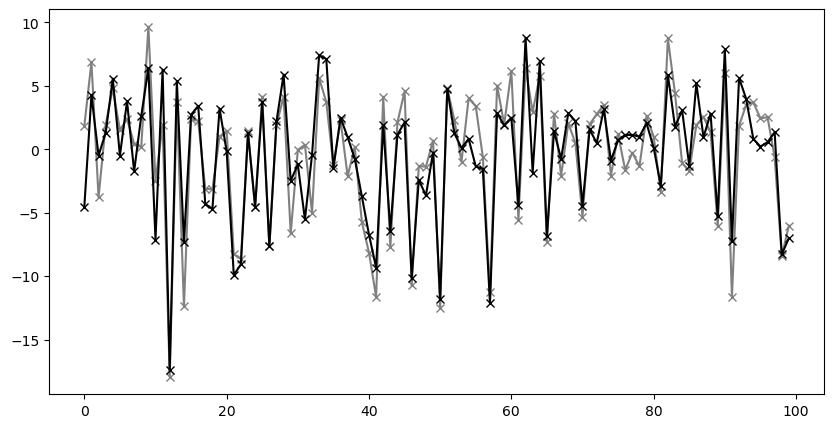

In [45]:
## plot validation set results:
with torch.no_grad():
    y_real = y_val[:, -1, :]
    y_hat  = model(X_val)[:, -1, :] # you take the last prediction (last of 2nd element of 3D tensor)
    print('>> RMSE validation:',np.sqrt(loss_fn(y_hat, y_real)).detach().numpy() )
# plot
plt.figure(figsize=(10,5))
plt.plot(y_real[:100], c='grey',marker='x')
plt.plot(y_hat[:100], c='black',marker='x')
plt.show()

In [30]:
print('done')

done
